# DS specific traits clustering

Marc Subirana-Granés (2024)

Description

# Load libraries/modules

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ccc.coef import ccc
from scipy.spatial.distance import squareform
import os
from pyprojroot.here import here
from sklearn.cluster import AgglomerativeClustering

# Load data

In [5]:
# define output nb
output_nb_path = here('output/nbs/ds_specific_traits_clustering')

if not os.path.exists(output_nb_path):
    os.makedirs(output_nb_path)

ds_multiplier_z_path = here(os.path.join("output", "nbs", "ds_specific_traits", "ds_multiplier_z.pkl"))
ds_multiplier_z = pd.read_pickle(ds_multiplier_z_path)

ds_multiplier_z.head()

,LV52,LV147,LV83,LV15,LV831,LV104,LV56,LV267,LV502,LV327,...,LV90,LV483,LV186,LV86,LV100,LV654,LV71,LV145,LV618,LV815
GAS6,0.00000,0.000000,0.016325,0.000000,0.000000,0.000000,0.072040,0.000000,3.11989,0.014619,...,0.0,0.001009,0.0,0.071566,0.051652,0.00000,0.198048,0.013209,0.000000,0.000000
MMP14,0.00000,0.009848,0.000000,0.079117,0.000000,0.000000,0.039415,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.000000,0.038994,0.00000,0.000000,0.001456,0.067141,0.020853
DSP,0.00000,0.000000,0.000000,0.000000,0.000000,0.010437,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.015406,0.095349,0.00000,0.000000,0.000000,0.002457,0.000000
MARCKSL1,0.01781,0.035666,0.000000,0.639242,0.110857,0.000000,0.688063,0.000000,0.00000,0.009175,...,0.0,0.000000,0.0,0.000000,0.060391,0.00000,0.000000,0.000000,0.000000,0.000000
SPARC,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016971,0.00000,0.050921,...,0.0,0.131879,0.0,0.003018,0.000000,0.01752,0.012957,0.000000,0.088446,0.000000


In [6]:
def hierarchical_clustering(correlation_matrix, distance_threshold):
    # Compute the distance matrix from the correlation matrix
    distance_matrix = 1 - correlation_matrix

    # Perform Agglomerative Clustering
    clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=distance_threshold)
    clusters = clustering.fit_predict(distance_matrix)

    # Create a DataFrame to store the clusters
    clusters_df = pd.DataFrame(clusters, columns=['cluster'])
    clusters_df.index = distance_matrix.index
    clusters_df['cluster'] = clusters_df['cluster'].apply(lambda x: 'CL' + str(x))

    # Reset index and rename columns
    new_clusters_df = clusters_df.reset_index().rename(columns={'index': 'LVs'})

    # Count the number of LVs in each cluster
    cluster_counts = clusters_df['cluster'].value_counts().reset_index()
    cluster_counts.columns = ['cluster', 'counts']

    # Merge cluster counts with the cluster DataFrame
    result_df = new_clusters_df.merge(cluster_counts, on='cluster', how='left')
    result_df = result_df.sort_values(by=['counts', 'cluster'], ascending=[False, False])

    # Get the order of LVs based on cluster counts
    lv_order = result_df['LVs'].tolist()
    lv_order = [lv for lv in lv_order if lv in distance_matrix.columns]

    # Reorder the distance matrix based on the new LV order
    ordered_distance_matrix = distance_matrix.reindex(index=lv_order, columns=lv_order)

    return ordered_distance_matrix, clusters_df, result_df

def visualize_clusters(distance_matrix, clusters_df, result_df, size_heatmap_n=None, font_scale=1, label_font_size=10):
    cmap_rg = LinearSegmentedColormap.from_list(
        name='test',
        colors=['#006400', '#DAF7A6', '#C70039']
    )

    # Order the clusters_df to match the ordered distance matrix
    ordered_clusters_df = clusters_df.loc[result_df['LVs']]

    # Assuming that 'cluster' column contains the cluster IDs
    num_unique_clusters = ordered_clusters_df['cluster'].nunique()
    palette = sns.color_palette("husl", num_unique_clusters)
    np.random.shuffle(palette)
    color_dict = dict(zip(ordered_clusters_df['cluster'].unique(), palette))

    # Map cluster labels to colors using the dictionary
    row_colors = ordered_clusters_df['cluster'].map(color_dict)

    sns.set(font_scale=font_scale)

    # Subset the distance matrix and row_colors if size_heatmap_n is specified
    if size_heatmap_n is not None:
        distance_matrix = distance_matrix.iloc[:size_heatmap_n, :size_heatmap_n]
        row_colors = row_colors.iloc[:size_heatmap_n]

    # Create the cluster map
    g = sns.clustermap(distance_matrix,
                       row_colors=row_colors,
                       figsize=(25, 25),
                       cmap=cmap_rg,
                       cbar_pos=None,
                       row_cluster=False,
                       col_cluster=False,
                       yticklabels=True,
                       xticklabels=True)

    # Adjust subplot parameters to remove white space
    g.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

    # Adjust the heatmap position if needed
    heatmap_position = [0.05, 0.05, 0.9, 0.9]
    g.ax_heatmap.set_position(heatmap_position)

    # If row colors are present, adjust their position to align with the heatmap
    if hasattr(g, 'ax_row_colors'):
        row_colors_position = [0.02, 0.05, 0.02, 0.9]
        g.ax_row_colors.set_position(row_colors_position)

    # Rotate the labels for better readability
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=label_font_size)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=label_font_size)

    # Show the plot
    plt.show()


In [44]:
cm_ds_multiplier_z = ds_multiplier_z.corr()
ds_ordered_distance_matrix, ds_clusters_df, ds_dp_result_df = hierarchical_clustering(cm_ds_multiplier_z, 0.7)

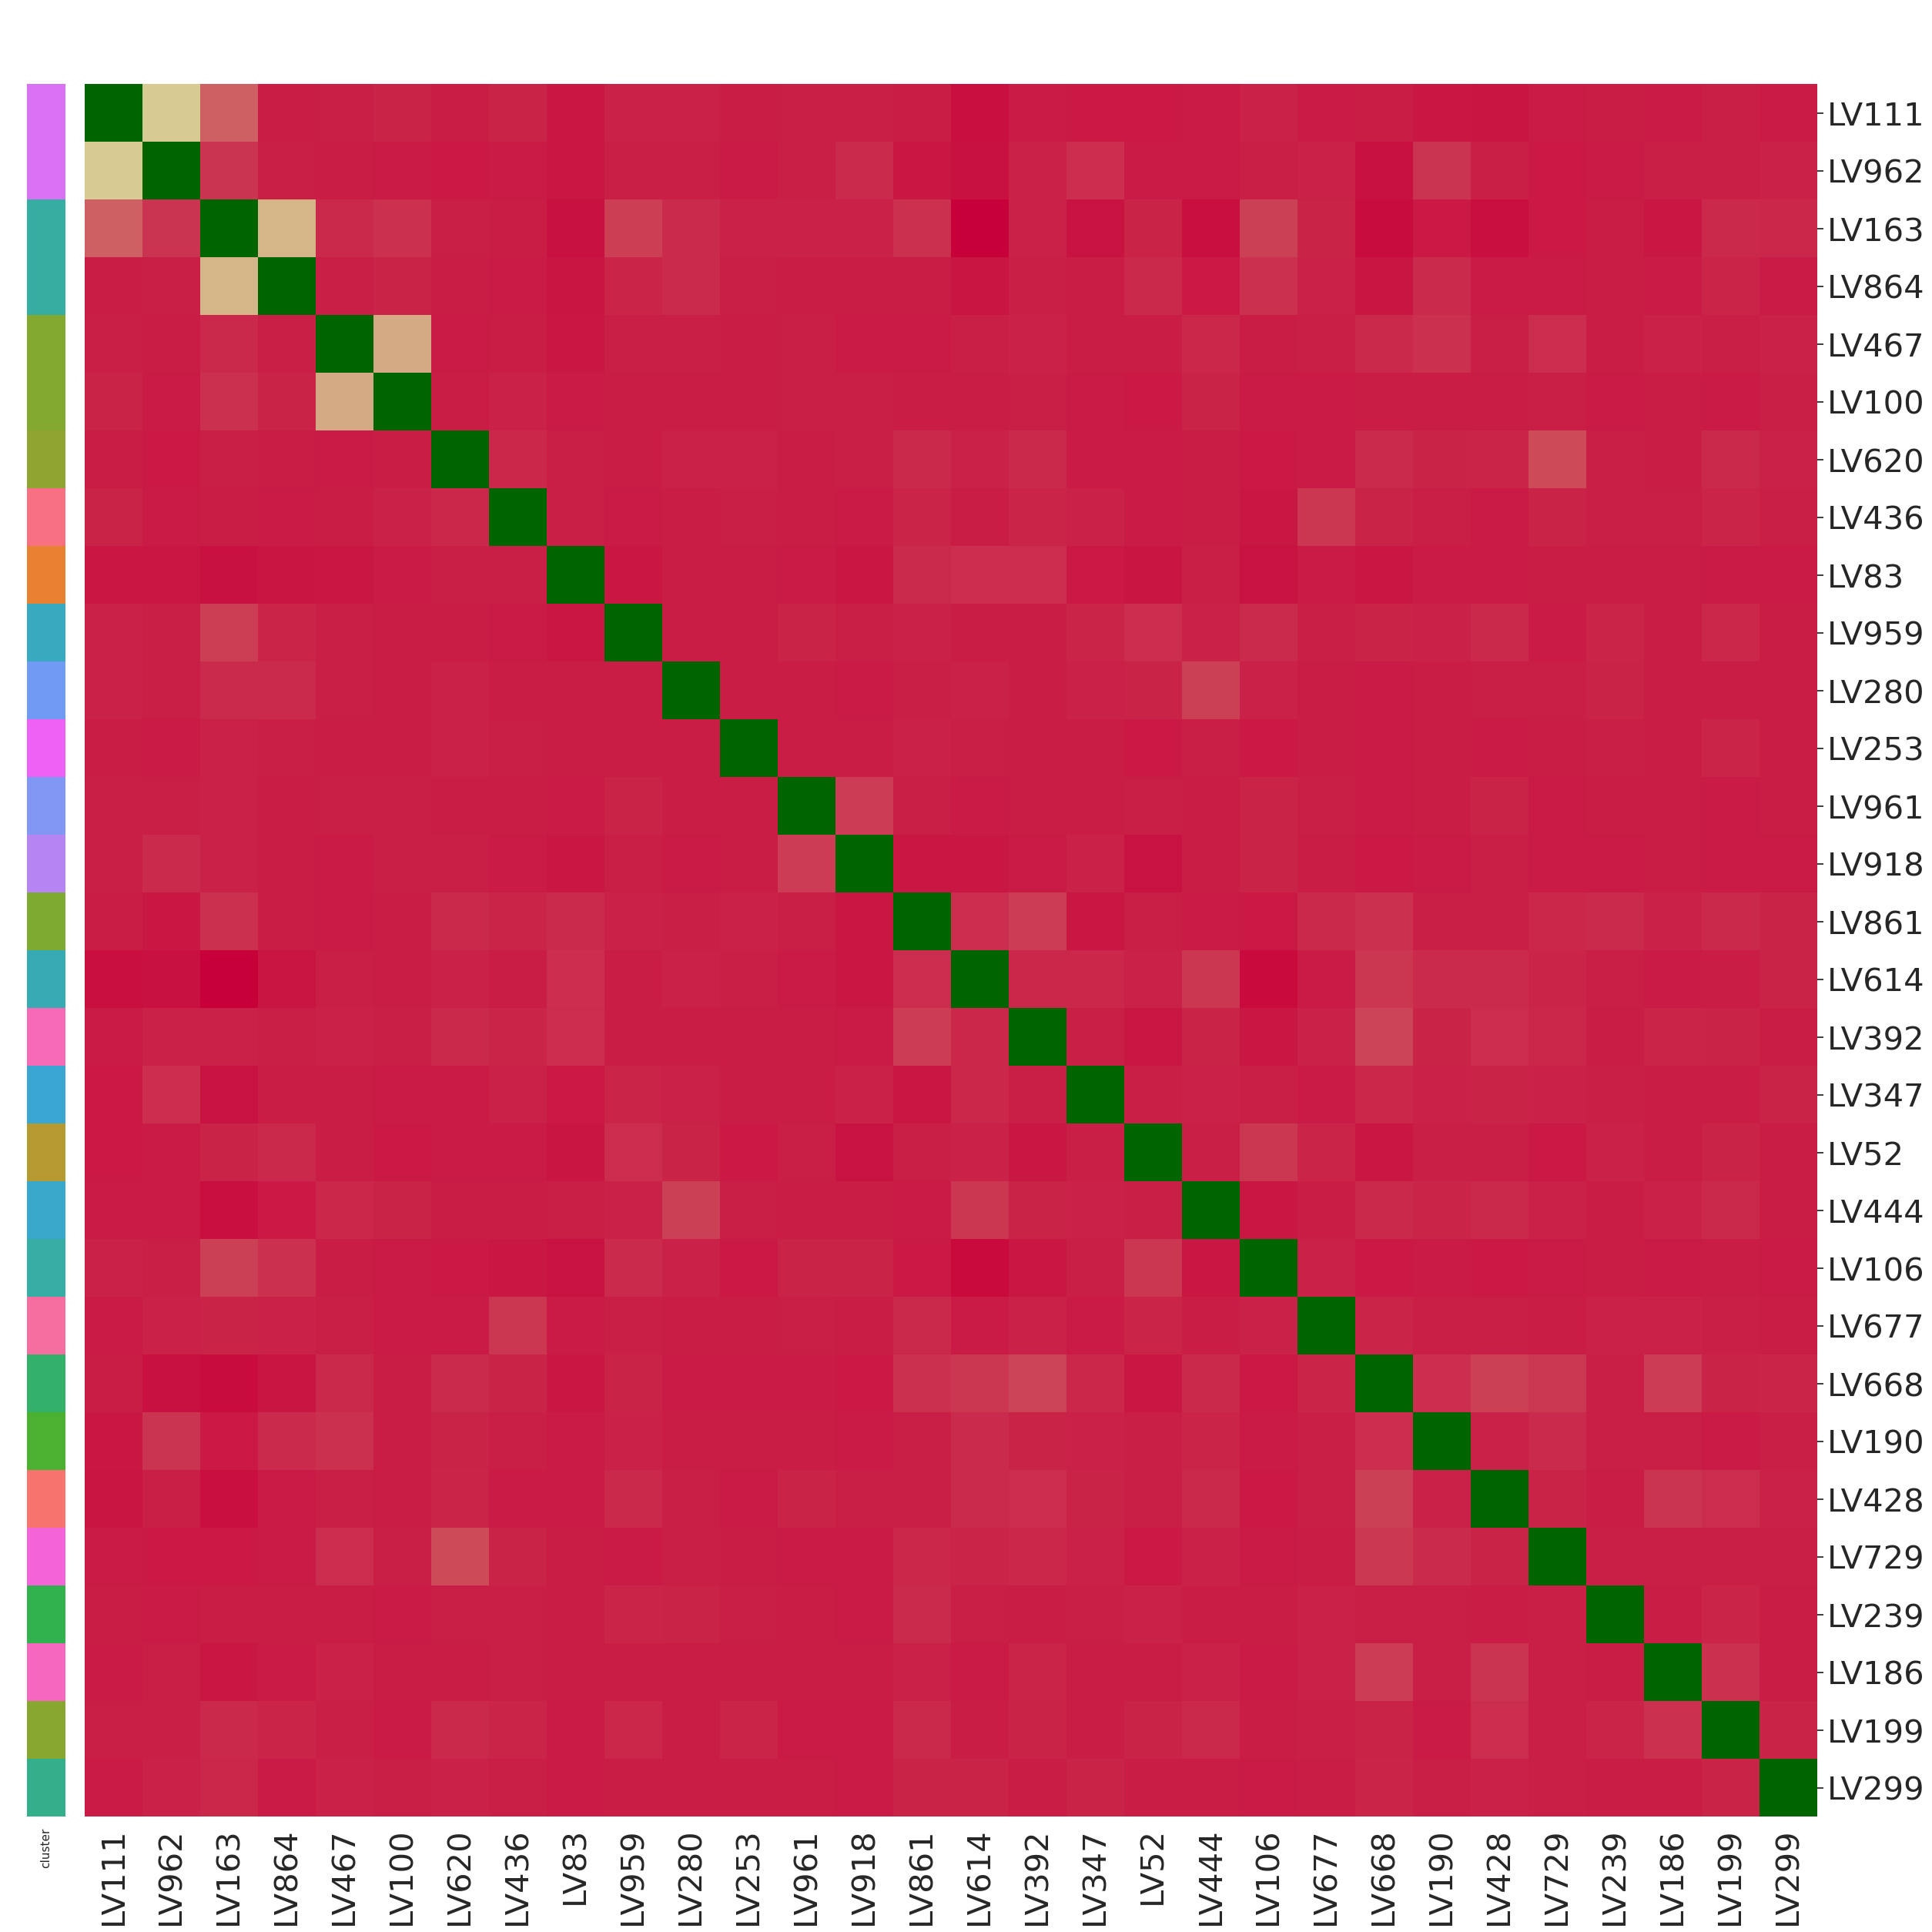

In [45]:
visualize_clusters(ds_ordered_distance_matrix, ds_clusters_df, ds_dp_result_df,font_scale=1, label_font_size=30, size_heatmap_n=30)

In [50]:
names = [
    "LV111", "LV962", "LV163", "LV864", "LV467", "LV100", 
    "LV620", "LV436", "LV83", "LV959", "LV280", "LV253", 
    "LV961", "LV918", "LV861", "LV614", "LV392", "LV347", 
    "LV52", "LV444", "LV106", "LV677", "LV668", "LV190", 
    "LV428", "LV729", "LV239", "LV186", "LV199", "LV299"
]

filtered_df = cm_ds_multiplier_z.loc[names, names]

filtered_df

,LV111,LV962,LV163,LV864,LV467,LV100,LV620,LV436,LV83,LV959,...,LV106,LV677,LV668,LV190,LV428,LV729,LV239,LV186,LV199,LV299
LV111,1.000000,0.373214,0.137927,-0.002191,0.001876,0.009062,-0.006175,0.007074,-0.017715,0.002756,...,0.005905,-0.008166,-0.004468,-0.014550,-0.019692,-0.008471,-0.003758,-0.008141,0.000322,-0.007282
LV962,0.373214,1.000000,0.045377,-0.000485,-0.002745,-0.006485,-0.012378,-0.008688,-0.015579,0.000788,...,0.000095,0.002691,-0.030791,0.048058,-0.001206,-0.013462,-0.009677,-0.000053,-0.000614,0.003981
LV163,0.137927,0.045377,1.000000,0.325854,0.020417,0.039114,-0.000920,-0.005605,-0.030888,0.066144,...,0.072919,0.007094,-0.039948,-0.011718,-0.031615,-0.011887,-0.002823,-0.014867,0.021718,0.014855
LV864,-0.002191,-0.000485,0.325854,1.000000,0.001982,0.007015,-0.005841,-0.006280,-0.021618,0.013485,...,0.037873,0.002909,-0.018846,0.024632,-0.008576,-0.008872,-0.005605,-0.007690,0.014211,-0.008298
LV467,0.001876,-0.002745,0.020417,0.001982,1.000000,0.302185,-0.006245,-0.003594,-0.014659,0.001106,...,-0.003298,0.000894,0.022262,0.035831,0.000041,0.028945,-0.005307,0.002441,0.001309,0.002174
LV100,0.009062,-0.006485,0.039114,0.007015,0.302185,1.000000,-0.006120,0.002674,-0.006752,-0.005112,...,-0.007253,-0.006692,-0.002593,-0.003122,-0.002477,0.001915,-0.006251,-0.005955,-0.007647,0.001161
LV620,-0.006175,-0.012378,-0.000920,-0.005841,-0.006245,-0.006120,1.000000,0.016034,0.000168,-0.003062,...,-0.014116,-0.006958,0.024532,0.008854,0.011598,0.090031,-0.001243,-0.005239,0.020072,0.004051
LV436,0.007074,-0.008688,-0.005605,-0.006280,-0.003594,0.002674,0.016034,1.000000,0.000611,-0.006427,...,-0.016180,0.049493,0.010068,0.001139,-0.009279,0.008165,-0.001692,-0.001666,0.013697,0.001048
LV83,-0.017715,-0.015579,-0.030888,-0.021618,-0.014659,-0.006752,0.000168,0.000611,1.000000,-0.017372,...,-0.022907,-0.006607,-0.015079,-0.008404,-0.009634,-0.004901,-0.005141,-0.005702,-0.007175,-0.007057
LV959,0.002756,0.000788,0.066144,0.013485,0.001106,-0.005112,-0.003062,-0.006427,-0.017372,1.000000,...,0.023218,-0.000572,0.007855,0.002956,0.022300,-0.008574,0.012901,-0.004598,0.017608,-0.005596


In [47]:
cm_ds_multiplier_z = ds_multiplier_z.corr()
ds_ordered_distance_matrix, ds_clusters_df, ds_dp_result_df = hierarchical_clustering(cm_ds_multiplier_z, 0.9)

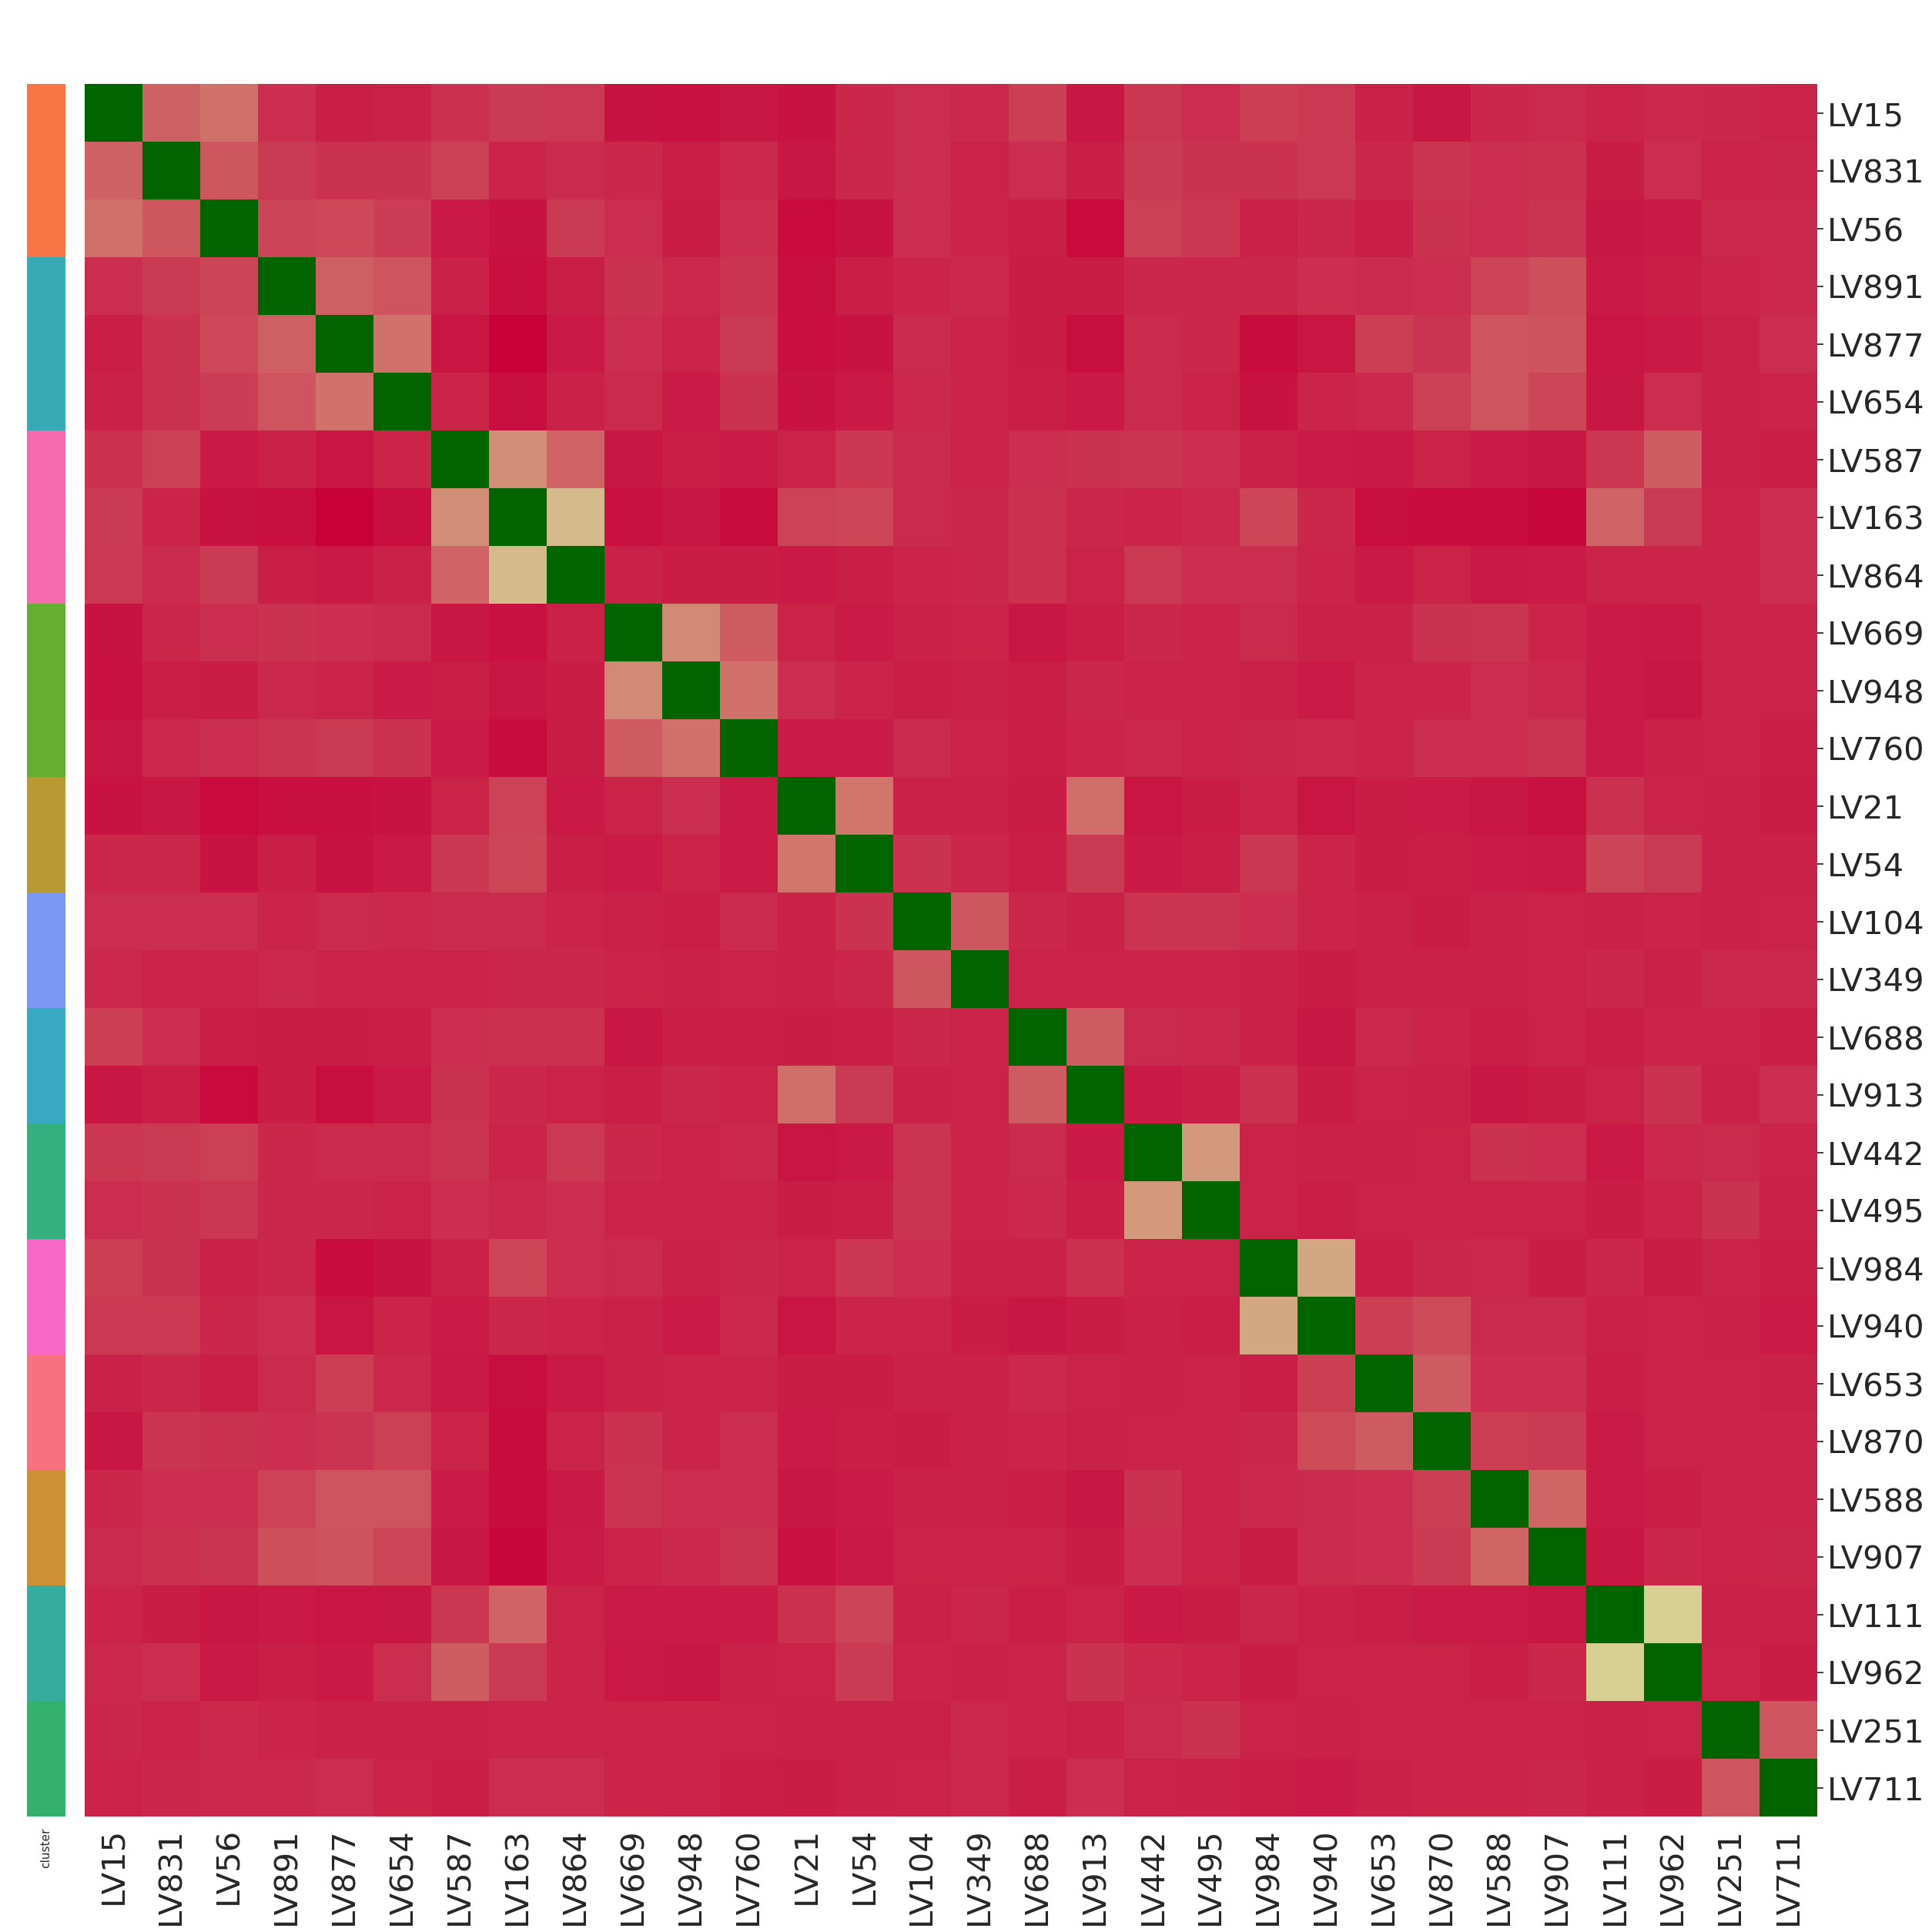

In [48]:
visualize_clusters(ds_ordered_distance_matrix, ds_clusters_df, ds_dp_result_df,font_scale=1, label_font_size=30, size_heatmap_n=30)

In [49]:
names = [
    'LV15', 'LV831', 'LV56', 'LV891', 'LV877', 'LV654', 'LV587', 'LV163', 'LV864',
    'LV669', 'LV948', 'LV760', 'LV21', 'LV54', 'LV104', 'LV349', 'LV688', 'LV913',
    'LV442', 'LV495', 'LV984', 'LV940', 'LV653', 'LV870', 'LV588', 'LV907', 'LV111',
    'LV962', 'LV251', 'LV711'
]

filtered_df = cm_ds_multiplier_z.loc[names, names]

filtered_df

,LV15,LV831,LV56,LV891,LV877,LV654,LV587,LV163,LV864,LV669,...,LV984,LV940,LV653,LV870,LV588,LV907,LV111,LV962,LV251,LV711
LV15,1.000000,0.132429,0.166916,0.022806,-0.012156,-0.006825,0.026460,0.046291,0.045052,-0.038101,...,0.054573,0.042452,-0.009065,-0.027460,0.006421,0.014374,0.002289,0.010254,0.004678,-0.001478
LV831,0.132429,1.000000,0.109504,0.048851,0.031183,0.029262,0.059001,0.002370,0.013102,0.005350,...,0.029185,0.041420,0.003930,0.035245,0.020332,0.026022,-0.018174,0.017544,-0.002405,0.006533
LV56,0.166916,0.109504,1.000000,0.069612,0.074825,0.052919,-0.026039,-0.035598,0.046112,0.016761,...,-0.007373,0.002972,-0.012748,0.031005,0.017927,0.036178,-0.030978,-0.026418,0.010154,0.007478
LV891,0.022806,0.048851,0.069612,1.000000,0.128641,0.105032,-0.005766,-0.044918,-0.012626,0.029043,...,0.003045,0.021345,0.013165,0.022572,0.065123,0.092528,-0.025981,-0.011166,-0.000326,0.007039
LV877,-0.012156,0.031183,0.074825,0.128641,1.000000,0.167733,-0.033294,-0.081703,-0.024156,0.022005,...,-0.054896,-0.033741,0.055486,0.032833,0.104709,0.101300,-0.034773,-0.023287,-0.007527,0.018847
LV654,-0.006825,0.029262,0.052919,0.105032,0.167733,1.000000,-0.000182,-0.047846,-0.006492,0.014961,...,-0.035766,-0.000832,0.010251,0.061394,0.108299,0.073740,-0.028399,0.015611,-0.008480,0.000986
LV587,0.026460,0.059001,-0.026039,-0.005766,-0.033294,-0.000182,1.000000,0.234558,0.135349,-0.027860,...,-0.009533,-0.019472,-0.024848,-0.001633,-0.021244,-0.026875,0.040826,0.124644,-0.008037,-0.010101
LV163,0.046291,0.002370,-0.035598,-0.044918,-0.081703,-0.047846,0.234558,1.000000,0.325854,-0.042043,...,0.074219,0.004163,-0.050637,-0.052201,-0.054209,-0.067542,0.137927,0.045377,0.000644,0.016966
LV864,0.045052,0.013102,0.046112,-0.012626,-0.024156,-0.006492,0.135349,0.325854,1.000000,-0.006173,...,0.016135,0.001016,-0.023193,-0.003903,-0.026593,-0.022381,-0.002191,-0.000485,0.001032,0.017206
LV669,-0.038101,0.005350,0.016761,0.029043,0.022005,0.014961,-0.027860,-0.042043,-0.006173,1.000000,...,0.015163,-0.007798,-0.009654,0.030401,0.035421,0.000851,-0.022178,-0.026326,-0.003025,-0.000834
